In [1]:
from sklearn.cluster import SpectralClustering, DBSCAN, AffinityPropagation
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sn

from CGmodel import CGCalculator

contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #MHCpan
contactA = [5,7,9,24,25,34,45,59,63,66,67,70,74,77,80,81,84,97,99,113,114,116,123,133,143,146,147,152,155,156,159,160,163,167,171]
contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

weight = {3:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]}

In [2]:
def heatmap(Mat, order=None, size=(10,10)):
    # Mat = pd.read_csv(InCSV, index_col=0)
    Mat = Mat.add(Mat.T, fill_value=0)
    # print(Mat.index)
    if order:
        split = np.cumsum([len(sublist) for sublist in order])
        # print(split)
        flat_order = [item for sublist in order for item in sublist]
        Mat = Mat[flat_order]
        Mat = Mat.reindex(flat_order)
    # print(Mat.index, Mat.columns)

    plt.figure(figsize=size, facecolor="w")
    
    sn.heatmap(Mat, square=True, xticklabels=True, yticklabels=True)
    for line in split[:-1]:
        plt.axhline(y=line, color='y', linestyle='-')
        plt.axvline(x=line, color='y', linestyle='-')
    plt.show()
    return

def DBSCAN_cluster(InCSV):
    Mat = pd.read_csv(InCSV, index_col=0)
    Mat = Mat.add(Mat.T, fill_value=0)
    clustering = DBSCAN(eps=9, min_samples=2, metric="precomputed").fit(Mat)
    print(clustering.labels_)

    return

def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

def dendro(Mat, OutTreeFile):
    # Mat = pd.read_csv(InCSV, index_col=0)
    Mat = Mat.add(Mat.T, fill_value=0)
    dists = squareform(Mat)
    # print(dists)
    A = linkage(dists, "single")
    # print(A)
    tree = to_tree(A,False)
    OutFile = getNewick(tree, "", tree.dist, Mat.index)
    with open(OutTreeFile, "w") as fh:
        fh.write(OutFile)
    # dendrogram(A, labels=Mat.index)
    # plt.title("HLAA")
    # plt.rcParams['axes.labelsize'] = 4
    # plt.show()
    return

In [3]:
def CGCalcMat(DATDir, OutCSV, contact, weight, pairwise=False):

    calc = CGCalculator(DATDir, OutCSV, ContactResi=contact, ResiWeight=weight, Pairwise=pairwise)

    calc.CalcDist()

    return calc.DistMat

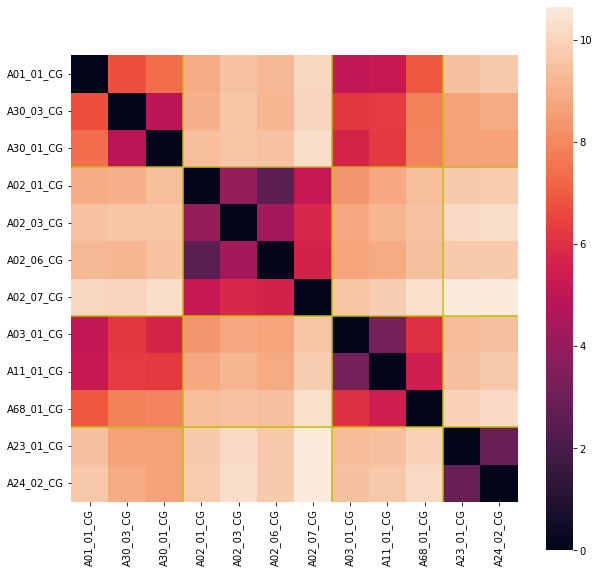

In [5]:
# crystal structure
A_crystal_mean_order = [['A01_01_CG', 'A30_03_CG', 'A30_01_CG'],
    ['A02_01_CG', 'A02_03_CG', 'A02_06_CG', 'A02_07_CG'],
    ['A03_01_CG', 'A11_01_CG', 'A68_01_CG'],
    ['A23_01_CG', 'A24_02_CG']]

Mat = CGCalcMat("../crystal/A_mean/CG_DAT", "../crystal/A_mean/HLA-A_mean_CG.csv", contact=contact, weight=weight)
heatmap(Mat, A_crystal_mean_order)

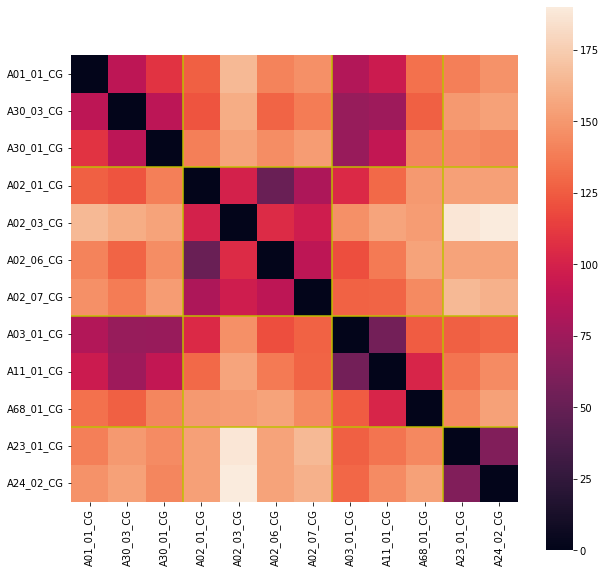

In [4]:
# crystal structure pairwise
A_crystal_mean_order = [['A01_01_CG', 'A30_03_CG', 'A30_01_CG'],
    ['A02_01_CG', 'A02_03_CG', 'A02_06_CG', 'A02_07_CG'],
    ['A03_01_CG', 'A11_01_CG', 'A68_01_CG'],
    ['A23_01_CG', 'A24_02_CG']]

Mat = CGCalcMat("../crystal/A_mean/CG_DAT", "../crystal/A_mean/HLA-A_mean_CG.csv", contact=contact, weight=weight, pairwise=True)
heatmap(Mat, A_crystal_mean_order)

In [ ]:
B_crystal_mean_order = [["B07_02_CG","B35_01_CG","B42_01_CG","B51_01_CG","B53_01_CG"],
    ["B08_01_CG"],
    ["B14_02_CG","B27_03_CG","B27_04_CG","B27_05_CG","B27_06_CG","B27_09_CG","B39_01_CG"],
    ["B18_01_CG","B37_01_CG","B40_01_CG","B40_02_CG","B44_02_CG","B44_03_CG"],
    ["B57_01_CG","B58_01_CG"],
    ["B15_01_CG","B46_01_CG"]]

Mat = CGCalcMat("../crystal/B_mean/CG", "../crystal/A_mean/HLA-B_mean_CG.csv", contact=contact, weight=weight)
heatmap(Mat, B_crystal_mean_order)